## Matcha Litteraturbanken personer utan bild i WD med SPA
Nedan test att hitta kandidater som saknar bild och är kopplade till Litteratur banken me saknar bild

* denna [Notebook](https://github.com/salgo60/spa2Commons/blob/main/Notebook/Litteraturbanken%20SPA.ipynb)
* [video](https://youtu.be/j8Pe-7E4pT0)
  * se även [GITHUB SPA2Common](https://github.com/salgo60/spa2Commons) / [video](https://www.youtube.com/watch?v=B3moN36PsNo)
  * [Notebook samma som Litteraturbanken LIBRISXL](https://github.com/salgo60/spa2Commons/blob/main/Notebook/Litteraturbanken%20-%20samma%20som.ipynb)
  
  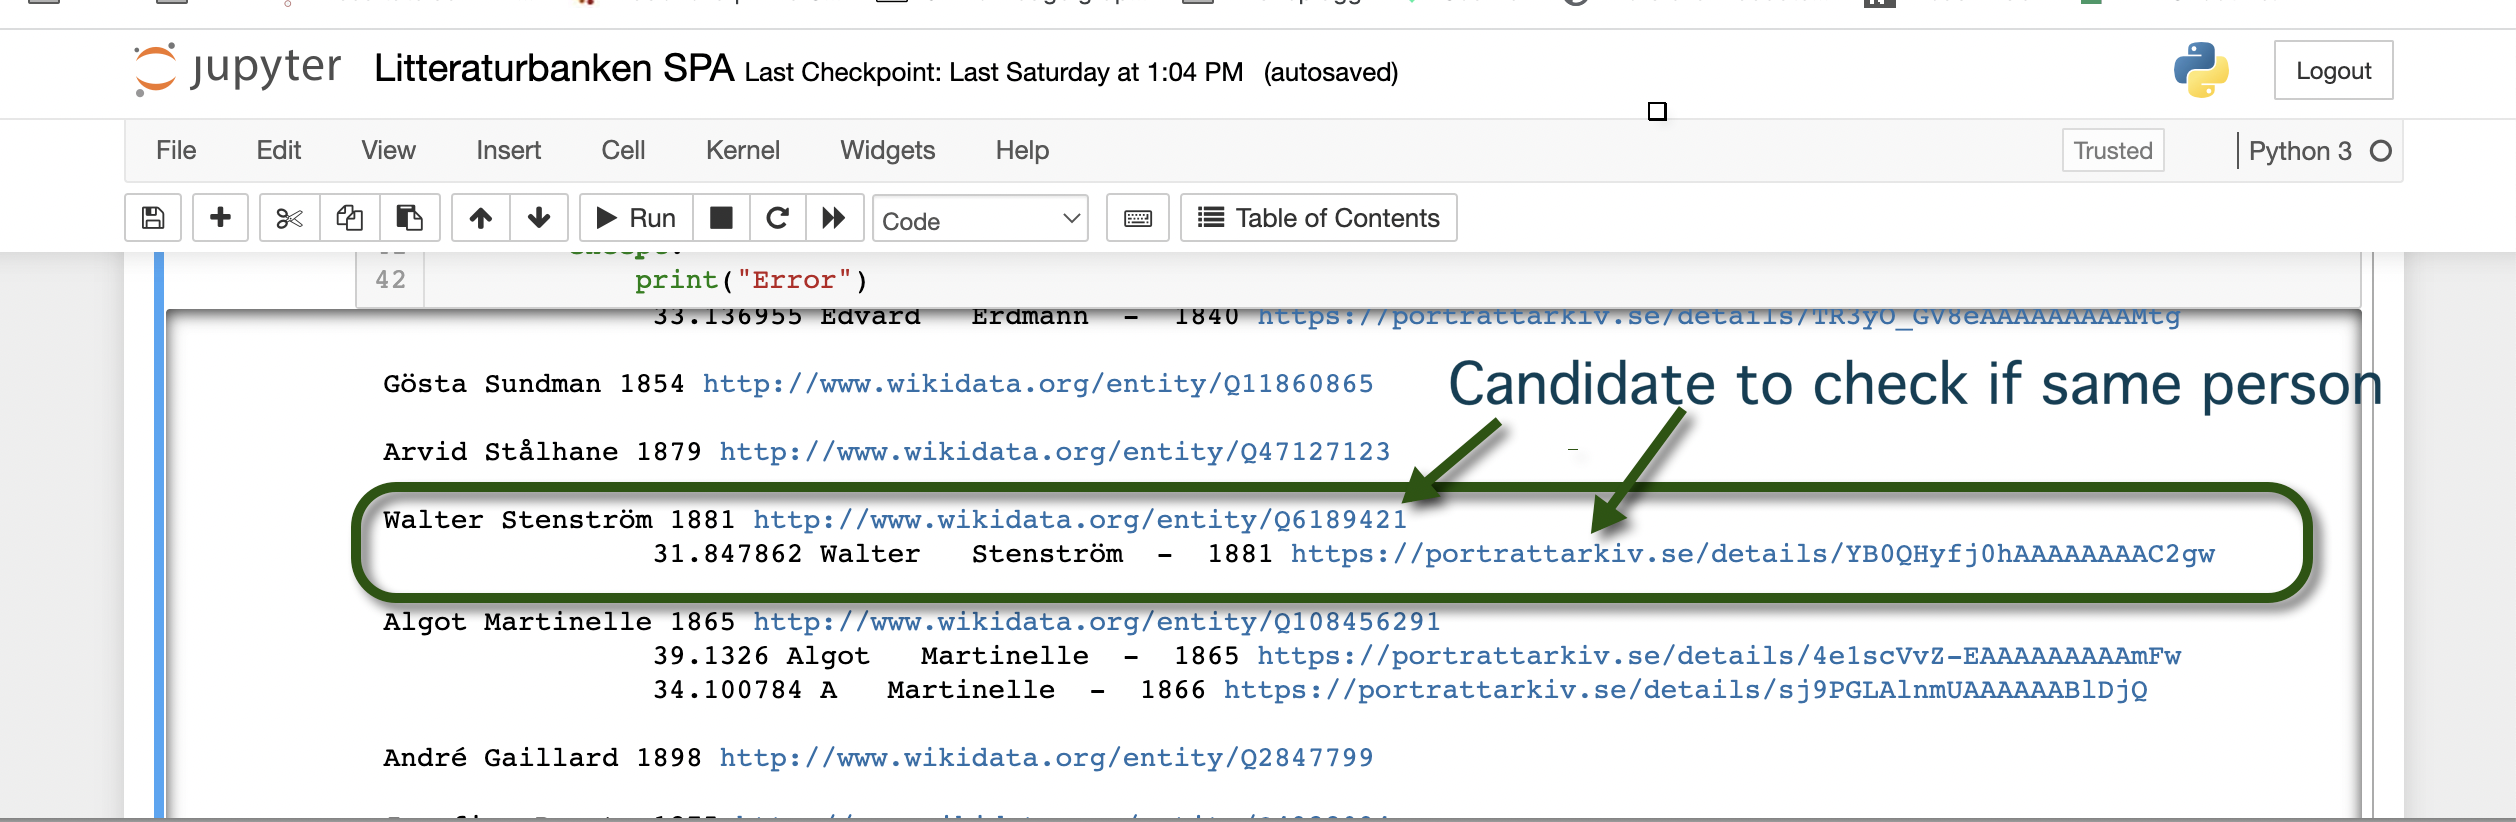

In [1]:
from datetime import datetime
start_time  = datetime.now()
print("Last run: ", start_time)


Last run:  2023-01-02 11:20:46.750999


In [2]:
# pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/

import pandas as pd
import sys,json
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

#https://w.wiki/4J4B
queryLittNoPic = """SELECT ?item ?itemLabel (year(?born) as ?year) ?statements ?Litteraturbankenid
 (CONCAT(?itemLabel," ",str(year(?born))) AS ?search) WHERE {
   ?item wdt:P5101 ?Litteraturbankenid ;
         wikibase:statements ?statements .
 # FILTER (?statements <100)
  minus {?item wdt:P18 ?img}
  OPTIONAL{?item wdt:P569 ?born}
  FILTER (year(?born) < 1900)
  FILTER (year(?born) > 1800)
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}  order by desc(?statements)
"""


def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


results = get_results(endpoint_url, queryLittNoPic)


def get_sparql_dataframe(endpoint_url, query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    user_agent = "salgo60/%s.%s" % (sys.version_info[0], sys.version_info[1])
 
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

WDLittNoPic = get_sparql_dataframe(endpoint_url, queryLittNoPic)
WDLittNoPic.shape

(426, 6)

In [3]:
WDLittNoPic

,item,itemLabel,year,statements,Litteraturbankenid,search
0,http://www.wikidata.org/entity/Q1787190,Mathilde Prager,1844,66,HolmErich,Mathilde Prager 1844
1,http://www.wikidata.org/entity/Q20652547,Franz Hoffmann,1814,55,HoffmannF,Franz Hoffmann 1814
2,http://www.wikidata.org/entity/Q1744240,Laura Kieler,1849,48,KielerL,Laura Kieler 1849
3,http://www.wikidata.org/entity/Q3121041,Gustaf Nordenskiöld,1868,48,NordenskiöldG,Gustaf Nordenskiöld 1868
4,http://www.wikidata.org/entity/Q389396,Johan Andersson,1820,46,AnderssonJohan,Johan Andersson 1820
...,...,...,...,...,...,...
421,http://www.wikidata.org/entity/Q52690406,J.E. Ahlstrand,1814,5,AhlstrandJE,J.E. Ahlstrand 1814
422,http://www.wikidata.org/entity/Q100605054,Heinrich Ortenburg,1850,5,OrtenburgH,Heinrich Ortenburg 1850
423,http://www.wikidata.org/entity/Q114115033,Josef Jonsson,1850,5,JonssonJ,Josef Jonsson 1850
424,http://www.wikidata.org/entity/Q115958630,Q115958630,1867,4,SalomonssonS,Q115958630 1867


In [4]:
import urllib3, json
http = urllib3.PoolManager() 
SPAdetail = "https://portrattarkiv.se/details/"
url= "https://portrattarkiv.se/endpoints/search.php"  
urlbasePic = "https://portrattarkiv.se/endpoints/file.php?id="

for index, row  in WDLittNoPic.iterrows():
    print("\n",row["search"],row["item"])
    encoded_body = json.dumps({
        "limit": "5",
        "from": "0",
        "birthyear":row["year"],
        "all":row["search"]
    })
    
    r = http.request('POST', url,
                 headers={'Content-Type': 'application/json'},
                 body=encoded_body)

    if r.status != 200:
        print(r.status)
        continue
    
    data = json.loads(r.data.decode('utf-8'),) 
    urls = []


    for h in data["hits"]["hits"]:
        id = h["_id"]
        #print(h)
        source = h["_source"]
        try:
            urlPicture = urlbasePic + id
#            urls.append(urlPicture)
            score = h["_score"]
            FirstName = source["FirstName"]
            LastName = source["LastName"]
            BirthYear = source["BirthYear"]
            if score > 30:
                print("\t\t",score,FirstName, " ", LastName, " - ", BirthYear,SPAdetail+id, "\t", )
        except:
            print("Error")


 Mathilde Prager 1844 http://www.wikidata.org/entity/Q1787190

 Franz Hoffmann 1814 http://www.wikidata.org/entity/Q20652547

 Laura Kieler 1849 http://www.wikidata.org/entity/Q1744240

 Gustaf Nordenskiöld 1868 http://www.wikidata.org/entity/Q3121041

 Johan Andersson 1820 http://www.wikidata.org/entity/Q389396

 Sixten Belfrage 1883 http://www.wikidata.org/entity/Q5569210

 Gottfrid Carlsson 1887 http://www.wikidata.org/entity/Q5603107

 Karl Fredrik Eneberg 1841 http://www.wikidata.org/entity/Q3431539

 August Zacharias Collin 1833 http://www.wikidata.org/entity/Q5610869
		 34.42948 August   Collin  -  1833 https://portrattarkiv.se/details/sj9PGLAlnmUAAAAAAB2-3g 	

 Laura Valentine 1814 http://www.wikidata.org/entity/Q6499526

 Jan de Liefde 1814 http://www.wikidata.org/entity/Q2414590

 Gösta Philip Armfelt 1830 http://www.wikidata.org/entity/Q16162603

 Hjalmar Lindroth 1878 http://www.wikidata.org/entity/Q6149708

 Anton Benedikt Reichenbach 1807 http://www.wikidata.org/entity/Q


 Richard Melander 1857 http://www.wikidata.org/entity/Q26399400
		 32.60173 Johan   Melander  -  1857 https://portrattarkiv.se/details/sj9PGLAlnmUAAAAAABLzhQ 	
		 32.32615 Johan   Melander  -  1857 https://portrattarkiv.se/details/sj9PGLAlnmUAAAAAABLzpw 	
		 32.256813 Richard   Melander  -  1857 https://portrattarkiv.se/details/I_2wtd5VefAAAAAAAAAcoQ 	
		 32.153202 Johan   Melander  -  1857 https://portrattarkiv.se/details/sj9PGLAlnmUAAAAAABLzpg 	
		 32.01941 Richard   Melander  -  1857 https://portrattarkiv.se/details/I_2wtd5VefAAAAAAAAAcpA 	

 Carl Herman Levin 1816 http://www.wikidata.org/entity/Q5948510
		 35.797485 Carl   Levin  -  1816 https://portrattarkiv.se/details/WQknIBFpuuAAAAAAAANgPw 	
		 30.240267 Carl   Levin  -  1816 https://portrattarkiv.se/details/rkIpfGqHXrAAAAAAAAB3RQ 	

 Ingeborg Wallenius 1832 http://www.wikidata.org/entity/Q54819982

 Johan Joachim Flodin 1814 http://www.wikidata.org/entity/Q24879251

 Harald Liedbeck 1851 http://www.wikidata.org/entity/Q1068161

		 33.462635 Carl   Rydström  -  1819 https://portrattarkiv.se/details/sj9PGLAlnmUAAAAAACbk_Q 	

 Carl Sundbeck 1865 http://www.wikidata.org/entity/Q6195355

 Julius Humble 1835 http://www.wikidata.org/entity/Q16649444
		 34.52864 Julius   Humble  -  1835 https://portrattarkiv.se/details/j6S8rJvx9lAAAAAAAAB5bg 	
		 34.445602 Julius   Humble  -  1835 https://portrattarkiv.se/details/seuNpYu6DKAAAAAAAABjYA 	
		 33.33396 Julius   Humble  -  1835 https://portrattarkiv.se/details/j6S8rJvx9lAAAAAAAAB5bQ 	
		 30.913288 Julius   Humble  -  1835 https://portrattarkiv.se/details/j6S8rJvx9lAAAAAAAAB5hA 	

 Hans Schulze 1823 http://www.wikidata.org/entity/Q16650314

 Georg Smirnoff 1840 http://www.wikidata.org/entity/Q17383968

 Oscar Busch 1844 http://www.wikidata.org/entity/Q18237961
		 34.30288 Oscar   Busch  -  1844 https://portrattarkiv.se/details/mLh5P0pzYFAAAAAAAAAg0Q 	
		 33.484474 Oscar   Busch  -  1844 https://portrattarkiv.se/details/mLh5P0pzYFAAAAAAAAAg0g 	
		 32.954414 Oscar   Busch  

		 36.639534 Anders   Hallin  -  1831 https://portrattarkiv.se/details/j6S8rJvx9lAAAAAAAAATuw 	
		 31.847261 Herman   Hallin  -  1831 https://portrattarkiv.se/details/j6S8rJvx9lAAAAAAAAATUQ 	

 Carl Henrik Rydberg 1820 http://www.wikidata.org/entity/Q108919118

 Carl Ludvig Wåhlin 1819 http://www.wikidata.org/entity/Q109906469

 August Wilhelm Stjerngranat 1803 http://www.wikidata.org/entity/Q113992377

 Knut Höökenberg 1808 http://www.wikidata.org/entity/Q5821560

 Carl Henrik Thörnberg 1834 http://www.wikidata.org/entity/Q27299898

 Hilma Svenson-Graner 1878 http://www.wikidata.org/entity/Q52509370

 Hans Jakob Lundborg 1825 http://www.wikidata.org/entity/Q5966187
		 41.409435 Hans Jakob   Lundborg  -  1825 https://portrattarkiv.se/details/sj9PGLAlnmUAAAAAAB4wDQ 	
		 32.480896 Hans   Lundborg  -  1825 https://portrattarkiv.se/details/sj9PGLAlnmUAAAAAAB4vSw 	
		 32.389236 Hans   Lundborg  -  1825 https://portrattarkiv.se/details/sj9PGLAlnmUAAAAAABHRDw 	
		 32.147064 Hans   Lundborg  -


 Anna Maria Schunck 1811 http://www.wikidata.org/entity/Q114310256

 Mathilda Ahlbom 1834 http://www.wikidata.org/entity/Q106594297

 Tekla Dahlén 1886 http://www.wikidata.org/entity/Q99771903

 Theodor Giertz 1833 http://www.wikidata.org/entity/Q108587959
		 30.94703 Theodor   Giertz  -  1833 https://portrattarkiv.se/details/sj9PGLAlnmUAAAAAABye3g 	

 Gustaf Selin 1835 http://www.wikidata.org/entity/Q108824333

 Hans Andersson 1817 http://www.wikidata.org/entity/Q108826166

 Erik Högström 1820 http://www.wikidata.org/entity/Q108869019
		 31.473808 Erik   Högström  -  1820 https://portrattarkiv.se/details/j6S8rJvx9lAAAAAAAACMUw 	

 Elias Walfrid Dufva 1840 http://www.wikidata.org/entity/Q108895895

 Gustaf Georg Silfversparre 1846 http://www.wikidata.org/entity/Q108896667

 Johan Wendel 1840 http://www.wikidata.org/entity/Q108899290

 Inga Schenfelt 1826 http://www.wikidata.org/entity/Q108916337
		 37.018215 Inga   Schenfelt  -  1826 https://portrattarkiv.se/details/YB0QHyfj0hAAAAAAAA